<a href="https://colab.research.google.com/github/RhysWangJunfei/Optimization-Leaks-Inferring-Private-Parameters-in-Optimization-Based-Decision-Systems-/blob/main/usenix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.io import loadmat
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import pdb;
import math
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Lambda,Concatenate,Dropout
from tensorflow.keras.models import load_model,Sequential,Model
import cvxpy as cp

In [ ]:
#solutions = loadmat('/content/drive/MyDrive/Postdoc/OPF/LMP_Attack_Case118/ieee118_solution_unbound.mat')['datapoints_list']
solutions = loadmat('/content/drive/MyDrive/Postdoc/OPF/LMP_Attack_Case118/118_lmp_pg.mat')['datapoints_list']
mat_gen = loadmat('/content/drive/MyDrive/Postdoc/OPF/LMP_Attack_Case118/gen118.mat')['gen']
mat_gencost = loadmat('/content/drive/MyDrive/Phd/PIA/normal_118_pf/case118_gencost.mat')['gencost']
gen_ids = mat_gen[:,0]-1
mat_y = loadmat('/content/drive/MyDrive/Phd/PIA/normal_118_pf/Y_bus118.mat')
Y_bus = mat_y['Y_bus118'].astype('complex64')
ptdf = loadmat('/content/drive/MyDrive/Postdoc/lmp/ptdf118.mat')

In [ ]:
mat_y

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 12 07:39:12 2021',
 '__version__': '1.0',
 '__globals__': [],
 'Y_bus118': <COOrdinate sparse matrix of dtype 'complex128'
 	with 476 stored elements and shape (118, 118)>}

In [ ]:
true_a = mat_gencost[:,4]
true_b = mat_gencost[:,5]

In [ ]:
true_a

array([0.01      , 0.01      , 0.01      , 0.01      , 0.02222222,
       0.11764706, 0.01      , 0.01      , 0.01      , 0.01      ,
       0.04545455, 0.03184713, 0.01      , 1.42857143, 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.52631579,
       0.04901961, 0.20833333, 0.01      , 0.01      , 0.06451613,
       0.0625    , 0.01      , 0.02557545, 0.0255102 , 0.01936483,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.02096436, 0.01      , 2.5       , 0.01647446,
       0.01      , 0.01      , 0.01      , 0.01      , 0.03968254,
       0.25      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.27777778, 0.01      , 0.01      , 0.01      ])

In [ ]:
grid_size = 118
gen_size = 54

In [ ]:
vm = solutions[:,:grid_size]
va = solutions[:,grid_size:grid_size*2]

In [ ]:
solutions[:,grid_size*2+39]

array([551.65782676, 547.33872617, 547.8510571 , ..., 522.30742145,
       544.08798032, 562.36460065])

In [ ]:
indices = np.array([0,5,6,7,8,12,15,17,20,21,23,24,25,27])
                    #21,22,23,24])
                    #21,22, 23,24,25])
                    #degree4:10,18
#,27,28,29,33,34,36,39
aaa=true_a[indices]
bbb=true_b[indices]
g_index_list =indices
Pg_list = []
LMP_list = []
PG_aggregate = np.zeros([solutions.shape[0]])
naive_index = 0
for g_index in g_index_list:
  a_i = aaa[naive_index]
  b_i = bbb[naive_index]
  gg = int(gen_ids[g_index])
  Pg = solutions[:,grid_size*2+g_index]
  Pg_list.append(Pg)
  PG_aggregate = PG_aggregate+Pg
  LMP = 2*a_i*Pg+b_i
  LMP_list.append(LMP)
  naive_index = naive_index+1
LMP_arr = np.array(LMP_list).T
Pg_arr = np.array(Pg_list).T

In [ ]:
LMP=np.asarray(LMP_list).T
PG=PG_aggregate

In [ ]:
LMPT = LMP_arr.T

In [ ]:
import numpy as np

def compute_bus_degrees(Y_bus, eps=1e-8):
    """
    Compute degree of each bus from Ybus matrix.

    Parameters
    ----------
    Y_bus : ndarray (n, n)
        Complex bus admittance matrix.
    eps : float
        Threshold for identifying a connection (default 1e-8).

    Returns
    -------
    degree : ndarray (n,)
        Degree of each bus.
    """
    # zero out diagonal (self-admittance not counted)
    Y_offdiag = Y_bus.copy()
    np.fill_diagonal(Y_offdiag, 0.0)

    # connection matrix (True if connected)
    connection = np.abs(Y_offdiag) > eps

    # degree = number of True entries per row
    degree = np.sum(connection, axis=1)
    return degree


In [ ]:
fully = Y_bus.toarray()

In [ ]:
degree = compute_bus_degrees(Y_bus.toarray())
print("Bus degrees:", degree)

Bus degrees: [2 2 3 2 5 2 2 3 2 1 4 7 2 2 5 2 6 2 4 2 2 2 4 3 3 2 4 2 2 4 3 5 2 4 2 2 6
 3 2 4 2 3 2 2 3 3 3 2 9 2 3 2 2 5 3 5 2 2 6 3 4 4 2 3 4 4 2 4 6 5 3 2 1 2
 5 2 6 2 2 7 2 3 3 2 5 2 1 2 4 2 2 6 2 5 2 5 2 2 2 8 2 2 4 3 5 3 2 2 2 4 1
 1 2 2 2 1 1 2]


In [ ]:
np.where(degree<4)


(array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  12,  13,  15,  17,
         19,  20,  21,  23,  24,  25,  27,  28,  30,  32,  34,  35,  37,
         38,  40,  41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,
         54,  56,  57,  59,  62,  63,  66,  70,  71,  72,  73,  75,  77,
         78,  80,  81,  82,  83,  85,  86,  87,  89,  90,  92,  94,  96,
         97,  98, 100, 101, 103, 105, 106, 107, 108, 110, 111, 112, 113,
        114, 115, 116, 117]),)

In [ ]:
degree[indices]

array([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2])

In [ ]:
import numpy as np

# X has shape (N, M): N buses, M time points
# Correlation matrix between buses:
C = np.corrcoef(LMPT-np.mean(LMPT,axis=0).reshape([1,-1]))

In [ ]:
S = np.sum(ptdf['H'],axis=0)[indices]

In [ ]:
S = degree[indices]
#np.sum(abs(C),axis=0)

In [ ]:
S_norm= np.sqrt(S)

In [ ]:
import numpy as np
#adv_points = [None] * N_b
def check_weighted_conditions_vec(LMP, PG, a_max=0.5, a_min=0.008, chunk_size=500):
    K, N_b = LMP.shape
    best_cond = np.ones(N_b) * np.inf
    for start in range(0, K, chunk_size):
        print(start)
        #pdb.set_trace()
        end = min(K, start + chunk_size)
        ΔLMP_chunk = LMP[start:end, None, :] - LMP[None, :, :]   # (chunk, K, N_b)
        ΔPG_chunk  = PG[start:end, None] - PG[None, :]           # (chunk, K)

        abs_LMP = np.abs(ΔLMP_chunk)
        mask_pos = ΔLMP_chunk > 0
        mask_neg = ΔLMP_chunk < 0

        C_exe_pos = np.sum(ΔLMP_chunk * mask_pos, axis=2)
        C_exe_neg = np.sum(ΔLMP_chunk * mask_neg, axis=2)
        conservative_factor=1
        # Loop over buses i
        for i in range(N_b):
            if best_cond[i]<aaa[i]:
              continue
            A = ΔLMP_chunk[:, :, i]
            B = ΔPG_chunk
            weight = S_norm/S_norm[i]
            weight[i]=0
            C_excl_i = np.sum(abs_LMP*weight.reshape([1,1,-1]), axis=2)
            # Mask valid regions (A>0,B>0)
            #mask_valid = (A > 0) & (B > 0)
            #if not np.any(mask_valid):
            #    continue

            # Exclude current bus i
            #C_excl_i = C_sum - abs_LMP[:, :, i]
            C_exe_pos_i = C_exe_pos - np.where(mask_pos[:, :, i], ΔLMP_chunk[:, :, i], 0)
            C_exe_neg_i = C_exe_neg - np.where(mask_neg[:, :, i], ΔLMP_chunk[:, :, i], 0)

            #Define D_i
            D_i1 = B+0.5*C_exe_pos_i/a_max+0.5*C_exe_neg_i/a_min
            D_i2 = -1*(B+0.5*C_exe_pos_i/a_min+0.5*C_exe_neg_i/a_max)
            case_i1 = np.where((D_i1>0))
            case_i2 = np.where((D_i2>0))

            #in case 2:
            num_cases = case_i2[0].shape
            D_i2_min = D_i2[case_i2]
            D_i2_max = -1*(B[case_i2]+0.5*C_exe_pos_i[case_i2]/a_max+0.5*C_exe_neg_i[case_i2]/a_min)
            cond2 = (np.sqrt(abs(A[case_i2]) * C_excl_i[case_i2]) + C_exe_pos_i[case_i2]) / (-2 * B[case_i2] - C_exe_neg_i[case_i2] / a_max)
            valid_self = (-(A[case_i2]/ D_i2_max) >= a_min/conservative_factor)&(-(A[case_i2]/ D_i2_min)<=a_max*conservative_factor)&(cond2>a_min)
            #pdb.set_trace()
                        # Update best
            cond_valid = np.where(valid_self, cond2, np.inf)
            min_val = np.min(cond_valid)
            if np.isfinite(min_val) and min_val < best_cond[i]:
                best_cond[i] = min_val
                #pdb.set_trace()
                agm = np.argmin(cond_valid)
                α_rel, β_idx = case_i2[0][agm], case_i2[1][agm]
                adv_points[i] = (start + α_rel, β_idx)
                print(best_cond)

            #in case 1:
            num_cases = case_i1[0].shape
            D_i1_min = D_i1[case_i1]
            D_i1_max = B[case_i1]+0.5*C_exe_pos_i[case_i1]/a_min+0.5*C_exe_neg_i[case_i1]/a_max
            cond1 = ((np.sqrt(abs(A[case_i1]) * C_excl_i[case_i1]) - C_exe_neg_i[case_i1]) / (2 * B[case_i1] + C_exe_pos_i[case_i1] / a_max))
            valid_self = ((A[case_i1]/ D_i1_max) >= a_min/conservative_factor)&((A[case_i1]/ D_i1_min)<=a_max*conservative_factor)&(cond1>a_min)
            cond_valid = np.where(valid_self, cond1, np.inf)
            if cond_valid.shape[0]>0:
              min_val = np.min(cond_valid)
              if np.isfinite(min_val) and min_val < best_cond[i]:
                  best_cond[i] = min_val
                  #pdb.set_trace()
                  agm = np.argmin(cond_valid)
                  α_rel, β_idx = case_i1[0][agm], case_i1[1][agm]
                  adv_points[i] = (start + α_rel, β_idx)
                  print(best_cond)

            del valid_self,cond_valid,cond2, D_i1, D_i2,case_i1,case_i2,C_excl_i,D_i2_min,D_i2_max
        del ΔLMP_chunk, ΔPG_chunk, abs_LMP, C_exe_pos, C_exe_neg
    return best_cond, adv_points


In [ ]:
aaa

array([0.01      , 0.11764706, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.04901961, 0.20833333,
       0.01      , 0.06451613, 0.0625    , 0.02557545])

In [ ]:
ttt = np.asarray(LMP_list).T
K, N_b = ttt.shape
adv_points = [None] * N_b
best_cond, adv_points = check_weighted_conditions_vec(np.asarray(LMP_list).T, PG_aggregate, a_max=0.21,a_min=0.008,chunk_size=100)

0
[0.00992404        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093 0.0167962         inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093 0.0167962         inf        inf 0.0083799
        inf        inf        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093 0.0167962         inf        inf 0.0083799
        inf 0.00836276        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093 0.0167962         inf        inf 0.0083799
        inf 0.00800217        inf        inf        inf        inf
        inf        inf]
[0.00992404 0.01269093 0.0167962         inf        i

In [ ]:
aaa

In [ ]:
adv_points

In [ ]:
def fa(adv_points,a_list):
  new_a_list = np.zeros_like(a_list)
  for i in range(0,len(adv_points)):
    #pdb.set_trace()
    beta_i = adv_points[i][0]
    alpha_i = adv_points[i][1]
    A = LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]
    B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
    C=0
    for g in range(0,LMP_arr.shape[1]):
      if g!=i:
        c = (LMP_arr[alpha_i,g]-LMP_arr[beta_i,g])/(2*a_list[g])
        C = C+c
    #pdb.set_trace()
    new_a_list[i] = A/(2*(B+C))
    #print(B+C)
  return new_a_list

In [ ]:
a_list = [0.01]*g_index_list.shape[0]
for it in range(1,100):
  a_list = fa(adv_points,a_list)
  print(a_list)

In [ ]:
aaa

array([0.01      , 0.11764706, 0.01      , 0.01      , 0.01      ,
       0.04545455, 0.01      , 0.01      , 0.01      , 0.04901961,
       0.20833333, 0.01      ])

In [ ]:
sum_cross = np.sum(abs_LMP, axis=2, keepdims=True) - abs_LMP

In [ ]:
sum_cross.shape

(3000, 3000, 7)

In [ ]:
a_min_est = np.max(ratio_mat,axis=2)

In [ ]:
a_min_est

array([[0.        , 0.01438578, 0.02266487, ..., 0.01234893, 0.0045993 ,
        0.01185927],
       [0.01438578, 0.        , 0.01238491, ..., 0.00633784, 0.04202835,
        0.01789802],
       [0.02266487, 0.01238491, 0.        , ..., 0.01378918, 0.00528942,
        0.01123069],
       ...,
       [0.01234893, 0.00633784, 0.01378918, ..., 0.        , 0.00644158,
        0.00602681],
       [0.0045993 , 0.04202835, 0.00528942, ..., 0.00644158, 0.        ,
        0.01304343],
       [0.01185927, 0.01789802, 0.01123069, ..., 0.00602681, 0.01304343,
        0.        ]])

In [ ]:
import h5py

# Save arrays in compressed format
with h5py.File('data.h5', 'w') as f:
    f.create_dataset('LMP_arr', data=LMP_arr, compression='gzip')
    f.create_dataset('PG_aggregate', data=PG_aggregate, compression='gzip')



In [ ]:
data_size = 3000

In [ ]:
import gc
# Then load slices as needed:
with h5py.File('data.h5', 'r') as f:
    for i in range(0, 10349-3000,3000):
        flagg = False
        LMP_arr = f['LMP_arr'][i:i+3000]
        PG_aggregate = f['PG_aggregate'][i:i+3000]
        ΔLMP = LMP_arr[:, None, :] - LMP_arr[None, :, :]    # shape (K,K,N_b)
        ΔPG  = PG_aggregate[:, None] - PG_aggregate[None, :]  # shape (K,K)
        adv_points = [None]*ΔLMP.shape[2]
        for pi in range(0,ΔLMP.shape[2]):
          advs = check_conditions_jensen_vec(ΔLMP, ΔPG, pi)
          if len(advs[0])==0:
            print('cannot find your point in this batch')
            break
          adv_p = np.array([advs[0][2],advs[1][2]])
          adv_points[pi] = adv_p
          print('######Suceed!####')
        if any(arr.size > 0 for arr in adv_points):
          flagg = True
          a_list = [0.01]*g_index_list.shape[0]
          for it in range(1,100):
            a_list = fa(adv_points,a_list)
            print(a_list)
        del ΔLMP, ΔPG, LMP_arr, PG_aggregate
        gc.collect()  # force memory cleanup
        print(i)
        if flagg:
          break


/tmp/ipython-input-164892535.py:24: RuntimeWarning: invalid value encountered in divide
  condition = np.sqrt((K*np.abs(A).reshape([data_size,data_size,1]) * np.abs(C))/ (4 * denom.reshape([data_size,data_size,1])**2))
/tmp/ipython-input-164892535.py:29: RuntimeWarning: invalid value encountered in divide
  ccc = np.sum(np.nan_to_num(C / condition),axis=-1)
/tmp/ipython-input-164892535.py:31: RuntimeWarning: invalid value encountered in divide
  ratio = A / (2 * (B + ccc))


######Suceed!####
######Suceed!####
######Suceed!####
######Suceed!####
######Suceed!####
######Suceed!####
######Suceed!####
[0.01499275 0.11764398 0.00506728 0.00861942 0.00854813 0.00646322
 0.00639557]
[0.00731664 0.06248776 0.00909311 0.01499221 0.01148162 0.00697777
 0.00854907]
[ 0.00866341 -0.37228445  0.00842313  0.01048285  0.01273395  0.0113345
  0.00955531]
[0.00973854 0.07493212 0.01073601 0.0105778  0.01039668 0.00988067
 0.0095518 ]
[0.01006661 0.13408795 0.00927681 0.00959964 0.00982253 0.0103009
 0.00979361]
[0.00992424 0.09580026 0.010256   0.01012419 0.00994962 0.00963622
 0.00986699]
[0.00995736 0.13612865 0.00975289 0.00991362 0.01004122 0.01010539
 0.01003372]
[0.0099806  0.11057958 0.01015069 0.01009396 0.01003977 0.00991292
 0.00998416]
[0.01000404 0.12348605 0.00990329 0.00996114 0.01000272 0.01006872
 0.01000824]
[0.00999764 0.1138478  0.01005728 0.01002706 0.00999913 0.0099612
 0.00998599]
[0.01000026 0.1198829  0.00995979 0.00998029 0.00999756 0.01002319
 0.

In [ ]:
any_nonempty = any(arr.size > 0 for arr in adv_points)

In [ ]:
any_nonempty

True

In [ ]:
solutions[:,grid_size*2+24]

array([148.84277175, 151.62417875, 151.20104161, ..., 148.96843835,
       152.45038457, 147.9558944 ])

In [ ]:
ΔLMP = LMP_arr[:, None, :] - LMP_arr[None, :, :]    # shape (K,K,N_b)
ΔPG  = PG_aggregate[:, None] - PG_aggregate[None, :]  # shape (K,K)


In [ ]:
aaa

array([0.01      , 0.11764706, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.52631579, 0.04901961, 0.20833333, 0.01      , 0.01      ,
       0.06451613])

In [ ]:
import numpy as np

def check_conditions_jensen_vec(ΔLMP, ΔPG, i, a_min=0.005, a_max=0.3):
    A = ΔLMP[:,:,i]
    B = ΔPG
    C = -ΔLMP
    C[:,:,i]=0

    mask_pos = (C > 0)
    mask_neg = (C < 0)
    mask_pos[:,:,i]=False
    mask_neg[:,:,i]=False

    C_exe_neg_1 = np.sum((C*mask_neg) / a_min,axis=-1)
    C_exe_neg_2 = np.sum((C*mask_neg) / a_max,axis=-1)
    C_exe_pos_1 = np.sum((C*mask_pos) / a_max,axis=-1)
    C_exe_pos_2 = np.sum((C*mask_pos) / a_min,axis=-1)

    vvv=np.abs(B + C_exe_neg_1 + C_exe_pos_1)
    fff=np.abs(B + C_exe_neg_2 + C_exe_pos_2)
    denom = np.minimum(vvv,fff)

    K = ΔLMP.shape[2] - 1
    condition = np.sqrt((K*np.abs(A).reshape([data_size,data_size,1]) * np.abs(C))/ (4 * denom.reshape([data_size,data_size,1])**2))
    condition = np.nan_to_num(condition)
    check_c = (condition<a_min)
    check_max = np.sum((condition>aaa),axis=-1)
    check_cs = np.sum(check_c,axis=-1)
    ccc = np.sum(np.nan_to_num(C / condition),axis=-1)

    ratio = A / (2 * (B + ccc))
    good_ratio = (ratio>a_min)*(ratio<a_max)*(check_cs==1)*(check_max==0)
    advs = np.where(good_ratio == True)
    #pdb.set_trace()
    return advs

In [ ]:
adv_points = [None]*ΔLMP.shape[2]
for pi in range(0,ΔLMP.shape[2]):
  advs = check_conditions_jensen_vec(ΔLMP, ΔPG, pi)
  adv_p = np.array([advs[0][0],advs[1][0]])
  adv_points[pi] = adv_p

/tmp/ipython-input-2374104442.py:24: RuntimeWarning: invalid value encountered in divide
  condition = np.sqrt((K*np.abs(A).reshape([data_size,data_size,1]) * np.abs(C))/ (4 * denom.reshape([data_size,data_size,1])**2))
/tmp/ipython-input-2374104442.py:29: RuntimeWarning: invalid value encountered in divide
  ccc = np.sum(np.nan_to_num(C / condition),axis=-1)
/tmp/ipython-input-2374104442.py:31: RuntimeWarning: invalid value encountered in divide
  ratio = A / (2 * (B + ccc))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
pi

0

In [ ]:
a_list = [0.01]*g_index_list.shape[0]
for it in range(1,100):
  a_list = fa(adv_points,a_list)
  print(a_list)

In [ ]:
i=0
a_min = 0.005
a_max = 0.2

In [ ]:
C = -ΔLMP
C[:,:,i]=0

In [ ]:
  mask_pos = (C > 0)
  mask_neg = (C < 0)

In [ ]:
C_exe_neg_1 = np.sum((C*mask_neg) / a_min,axis=-1)
C_exe_neg_2 = np.sum((C*mask_neg) / a_max,axis=-1)
C_exe_pos_1 = np.sum((C*mask_pos) / a_max,axis=-1)
C_exe_pos_2 = np.sum((C*mask_pos) / a_min,axis=-1)

In [ ]:
vvv=np.abs(B + C_exe_neg_1 + C_exe_pos_1)
fff=np.abs(B + C_exe_neg_2 + C_exe_pos_2)
denom = np.minimum(vvv,fff)

In [ ]:
K = ΔLMP.shape[2] - 1
cond = np.sqrt(K * np.abs(A) * np.abs(C) / (4 * denom**2))

SyntaxError: invalid syntax (ipython-input-2977193209.py, line 2)

In [ ]:
condition = np.sqrt((np.abs(A).reshape([1000,1000,1]) * np.abs(C))/ (4 * denom.reshape([1000,1000,1])**2))

/tmp/ipython-input-2648047694.py:1: RuntimeWarning: invalid value encountered in divide
  condition = np.sqrt((np.abs(A).reshape([1000,1000,1]) * np.abs(C))/ (4 * denom.reshape([1000,1000,1])**2))


In [ ]:
condition = np.nan_to_num(condition)

In [ ]:
for pp in range(1,2):
  condition_i = condition[:,:,pp]
  good_ind = condition_i>a_min
  np.sum(good_ind)


In [ ]:
ccc = np.sum(C / condition_i.reshape([1000,1000,1]),axis=-1)
ccc = np.nan_to_num(ccc)

/tmp/ipython-input-717429801.py:1: RuntimeWarning: invalid value encountered in divide
  ccc = np.sum(C / condition_i.reshape([1000,1000,1]),axis=-1)


In [ ]:
ratio = np.nan_to_num(A / (2 * (B + ccc)))

/tmp/ipython-input-3577308978.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = A / (2 * (B + ccc))


In [ ]:
good_ratio = (ratio>a_min)*(ratio<a_max)

In [ ]:
np.where(good_ratio == True)

(array([  0,   0,   0, ..., 999, 999, 999]),
 array([180, 190, 194, ..., 737, 755, 859]))

In [ ]:
good_ratio[0,189]

np.False_

In [ ]:
good_ratio = (a_min <= ratio <= a_max)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
ccc = np.sum(C / cond) - C[i] / cond[i]  # exclude self term
ratio = A / (2 * (B + ccc))
if not (a_min <= ratio <= a_max):
    return False, None

In [ ]:
condition_i

array([[0.        , 0.00130824, 0.00196631, ..., 0.00228327, 0.0009205 ,
        0.00073933],
       [0.00130824, 0.        , 0.00124699, ..., 0.00032569, 0.00199297,
        0.00080056],
       [0.00196631, 0.00124699, 0.        , ..., 0.00225733, 0.00021029,
        0.00023925],
       ...,
       [0.00228327, 0.00032569, 0.00225733, ..., 0.        , 0.00242906,
        0.00155468],
       [0.0009205 , 0.00199297, 0.00021029, ..., 0.00242906, 0.        ,
        0.00105624],
       [0.00073933, 0.00080056, 0.00023925, ..., 0.00155468, 0.00105624,
        0.        ]])

In [ ]:
good_ind = condition_i>a_min
np.sum(good_ind)

np.int64(1814)

In [ ]:
g_cardinality = len(g_index_list)
#best_cond = np.ones(g_cardinality)*10
a_max = 0.2
a_min = 0.005
def check_conditions_jensen(LMP_arr,PG_aggregate,beta_i,alpha_i,i,best_cond):
  K=g_cardinality-1
  A = LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]
  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  if A<=0:
    return False, None
  C = np.zeros([LMP_arr.shape[1]])
  C_exe_neg_1 = 0
  C_exe_pos_1 = 0
  C_exe_neg_2 = 0
  C_exe_pos_2 = 0
  for g in range(0,LMP_arr.shape[1]):
    if g == i:
      continue
    c = LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]
    if c<0:
        C_exe_neg_1 = C_exe_neg_1+c/a_min
        C_exe_neg_2 = C_exe_neg_2+c/a_max
    else:
        C_exe_pos_1 = C_exe_pos_1+c/a_max
        C_exe_pos_2 = C_exe_pos_2+c/a_min
    C[g] = c
  #if i==1:
  #pdb.set_trace()
  denom = np.minimum(abs(B+C_exe_neg_1+C_exe_pos_1),abs(B+C_exe_neg_2+C_exe_pos_2))
  #print(B+(C_exe_pos+C_exe_neg))
  cond = np.sqrt(K*abs(A)*abs(C)/(4*np.square(denom)))
  #print(cond)
  cond[i] = a_min
  if np.any(cond<a_min):
    return False,None
  print(cond)
  ccc = 0
  for index_g in range(0,LMP_arr.shape[1]):
    if index_g!=i:
      ccc = ccc+C[index_g]/cond[index_g]
  pdb.set_trace()
  if (A/(2*(B+ccc))<a_min):
    return False,None
  if (A/(2*(B+ccc))>a_max):
    return False,None
  if np.max(cond)<np.max(best_cond):
    for pp in range(0,LMP_arr.shape[1]):
      best_cond[pp] = cond[pp]
    print('Best cond:'+str(cond))
  return True,best_cond

In [ ]:
flag,somehow = check_conditions_jensen(LMP_arr,PG_aggregate,577,659,0,np.ones(g_cardinality)*10)

[0.005      0.00654043 0.00663619 0.00515259 0.00697379 0.00561288
 0.00526219 0.006966   0.00693322 0.00693081]
> /tmp/ipython-input-3709464908.py(42)check_conditions_jensen()
     40       ccc = ccc+C[index_g]/cond[index_g]
     41   pdb.set_trace()
---> 42   if (A/(2*(B+ccc))<a_min):
     43     return False,None
     44   if (A/(2*(B+ccc))>a_max):

ipdb> c
Best cond:[0.005      0.00654043 0.00663619 0.00515259 0.00697379 0.00561288
 0.00526219 0.006966   0.00693322 0.00693081]


In [ ]:
aaa

array([0.01      , 0.02222222, 0.11764706, 0.01      , 0.01      ,
       0.01      , 0.03184713, 0.01      , 0.01      , 0.01      ])

In [ ]:
print(somehow)

None


In [ ]:
import random

K = 10348
adv_points = [None]*g_cardinality
best_conds = []
thresh = 1e12
for i in range(0,LMP_arr.shape[1]):
  ii=0
  best_cond = np.ones(g_cardinality)*10
  print("##searching for node:"+str(i))
  while 1:
    #pdb.set_trace()
    indices = np.random.randint(0,K-1, size=2)
    flag,somehow = check_conditions_jensen(LMP_arr,PG_aggregate,indices[0],indices[1],i,best_cond)
    if flag:
      adv_points[i] = indices
      best_cond = somehow
    ii=ii+1
    if np.all(best_cond<aaa):
      print('achieved!!!')
      break
    if ii>=thresh:
      break
  #pdb.set_trace()
  best_conds.append(best_cond)

'''import random

K = 1000
adv_points = []
ii=0
for i in range(0,LMP_arr.shape[1]):
  while 1:
    indices = np.random.randint(0,K-1, size=2)
    flag = check_conditions(LMP_arr,PG_aggregate,indices[0],indices[1],i)
    ii=ii+1
    #print("trying the "+str(ii)+"combinations of points for generator "+str(i))
    if flag == True:
      print(indices)
      adv_points.append(indices)
      break'''

#condition1 = ((LMP_g1[i]-LMP_g1[j])*(LMP_g2[i]-LMP_g2[k]))/((LMP_g2[j]-LMP_g2[i])*(LMP_g1[k]-LMP_g1[i]))
#condition2 = (Pg12[i]-Pg12[j])+((LMP_g2[j]-LMP_g2[i])*(Pg12[i]-Pg12[k]))/(LMP_g2[i]-LMP_g2[k])

##searching for node:0
Best cond:[0.005      0.07854712 0.2785353  0.11399239 0.19768523 0.15411775
 0.158521   0.19792497 0.14028186 0.29087534]
Best cond:[0.005      0.02183615 0.02635698 0.03222377 0.026819   0.01867956
 0.02176066 0.00844917 0.02784466 0.02788029]
Best cond:[0.005      0.00577493 0.00770385 0.00864122 0.01926341 0.01468016
 0.00969844 0.01257263 0.00904815 0.017383  ]
Best cond:[0.005      0.00808257 0.00808416 0.00596485 0.01602553 0.00568372
 0.00640945 0.01891806 0.01548308 0.00831878]
Best cond:[0.005      0.00557192 0.0069196  0.00748159 0.00549589 0.00705622
 0.01106332 0.00763832 0.00696075 0.01472329]
Best cond:[0.005      0.00594677 0.01078012 0.01358964 0.00984152 0.01213859
 0.00834842 0.00698974 0.01138986 0.00695578]
Best cond:[0.005      0.00690387 0.0059764  0.00835492 0.00855589 0.00730534
 0.00571561 0.00748792 0.01027984 0.00638655]
Best cond:[0.005      0.00653476 0.00607723 0.00649867 0.00869802 0.00752012
 0.00667006 0.00733816 0.00813567 0.007

In [ ]:
array([0.01      , 0.00692175, 0.00615077, 0.00251568, 0.00522678,
       0.00592431])

NameError: name 'array' is not defined

In [ ]:
adv_points

[array([ 1968, 10146]),
 array([10278,   662]),
 array([3990,  438]),
 array([9514, 9007]),
 array([9291, 8092]),
 array([8210, 3692]),
 array([  25, 3220]),
 array([8079, 5813]),
 array([  38, 4307]),
 array([5107, 5730])]

In [ ]:
LMP_arr[1914 ,:]

array([3.69576568, 3.72005147, 3.82305457])

In [ ]:
aaa

array([0.01      , 0.02222222, 0.11764706, 0.01      , 0.01      ,
       0.01      , 0.03184713, 0.01      , 0.01      , 0.01      ])

In [ ]:
[0.01]*g_index_list.shape[0]

[0.01, 0.01]

In [ ]:
a_list = [0.01]*g_index_list.shape[0]
for it in range(1,100):
  a_list = fa(adv_points,a_list)
  print(a_list)

[0.01436663 0.11764334 0.00797991 0.00623433 0.00789865 0.01114264
 0.00744045]
[0.00849046 0.03067285 0.01514529 0.00898354 0.01383948 0.01038915
 0.01670461]
[ 0.01108752 -0.08593601  0.00781769  0.00915024  0.0092741   0.00864838
  0.00918258]
[0.00869168 0.0450054  0.01209099 0.01208033 0.01241223 0.01083467
 0.01579185]
[ 0.01145142 -0.10688899  0.00788565  0.00992279  0.0088539   0.00967509
  0.00952533]
[0.00914694 0.0496895  0.01169219 0.01175987 0.01166354 0.0113161
 0.01510537]
[ 0.01135723 -0.1497637   0.00815829  0.00991288  0.00903572  0.00989464
  0.00985811]
[0.00929495 0.0558696  0.01132241 0.01150296 0.01144768 0.01115566
 0.01449482]
[ 0.01112729 -0.21237528  0.00835043  0.0100246   0.00921603  0.00995929
  0.01012874]
[0.0094144  0.06254211 0.01099086 0.01137788 0.01122807 0.01103333
 0.01399455]
[ 0.01096055 -0.33261693  0.0085174   0.01013095  0.00935268  0.01004058
  0.01036501]
[0.0095267  0.06935445 0.01073226 0.01126524 0.01104224 0.01094663
 0.01360018]
[ 0.01

In [ ]:
aaa

array([0.01      , 0.11764706, 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      ])

In [ ]:
true_a=np.array([0.02   , 0.0175 , 0.025,0.025])

In [ ]:
np.mean(abs(np.array(a_list)-true_a)/true_a)*100

np.float64(0.05568839860397415)

In [ ]:
import numpy as np

a = np.array([0.04302926, 0.25, 0.01])
n = len(a)

# Build matrix M
M = np.eye(n)
for i in range(n):
    for j in range(n):
        if i != j:
            M[i, j] = a[i] / a[j]

# Check rank
rank = np.linalg.matrix_rank(M)
print("Matrix M:\n", M)
print("Rank of M:", rank)

Matrix M:
 [[ 1.          0.17211704  4.302926  ]
 [ 5.80999999  1.         25.        ]
 [ 0.2324      0.04        1.        ]]
Rank of M: 1


In [ ]:
i=2

In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Input Parameters
# -----------------------------
A = np.array(A_list)                 # A1, A2, A3
D = np.array(D_list)              # D1, D2, D3
f = np.array(f_list)                 # f1, f2, f2 (assumed reused)
a = np.array(a_list)              # a1, a2, a3

# Initial guess bounds
b_min_init = np.array([15.0, 15.0, 15.0])
b_max_init = np.array([45.0, 45.0, 45.0])

# Convergence parameters
tol = 1e-5
max_iter = 10000

# -----------------------------
# Update Functions
# -----------------------------
def update_b_min(b, A, D, f, a):
    b1 = (D[0] + f[0]/2 * (b[1]/a[1] + b[2]/a[2])) / A[0]
    b2 = (D[1] + f[1]/2 * (b[0]/a[0] + b[2]/a[2])) / A[1]
    b3 = (D[2] + f[2]/2 * (b[0]/a[0] + b[1]/a[1])) / A[2]
    return np.array([b1, b2, b3])

# -----------------------------
# Fixed Point Iteration
# -----------------------------
b_min = b_min_init.copy()
b_max = b_max_init.copy()

for iteration in range(max_iter):
    print(iteration)
    b_min_new = update_b_min(b_min, A, D, f, a)
    b_max_new = update_b_min(b_max, A, D, f, a)
    #print(b_min_new)
    # Clamp to original bounds
    b_min_new = np.maximum(b_min_new, b_min_init)
    b_max_new = np.minimum(b_max_new, b_max_init)

    # Check convergence
    if np.all(np.abs(b_min_new - b_min) < tol) and np.all(np.abs(b_max_new - b_max) < tol):
        print(f"Converged in {iteration+1} iterations.")
        break

    b_min = b_min_new
    b_max = b_max_new

# -----------------------------
# Output Results
# -----------------------------
df = pd.DataFrame({
    'b_min': b_min,
    'b_max': b_max
}, index=['b1', 'b2', 'b3'])

print(df)


NameError: name 'A_list' is not defined

In [ ]:
adv_points = []

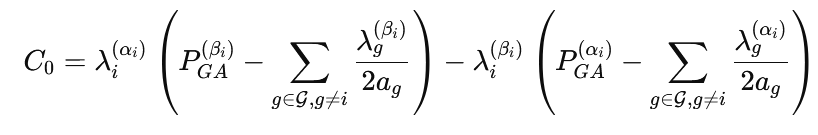

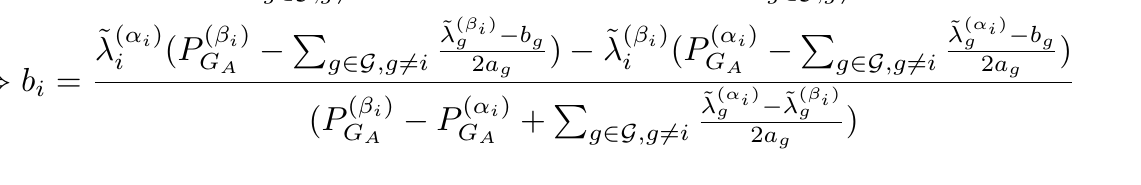

In [ ]:
true_b

array([20., 20., 40., 40., 40.])

In [ ]:
#Construct the matrix M:
#alpha_i, beta_i
def condition_check_for_b_new(LMP_arr,PG_aggregate,beta_i,alpha_i,i):
  D_1 = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  D_2 = 0
  C_g = []
  E1 = LMP_arr[alpha_i,i]*PG_aggregate[beta_i]-LMP_arr[beta_i,i]*PG_aggregate[alpha_i]
  E2 = 0
  for g in range(0,LMP_arr.shape[1]):
    if g == i:
        continue
    else:
      D_2 = D_2+(LMP_arr[alpha_i,g]-LMP_arr[beta_i,g])/(2*true_a[g])
      C_g.append((LMP_arr[alpha_i,i]-LMP_arr[beta_i,i]) /(2*true_a[g]))
      E2 = E2+(-LMP_arr[alpha_i,i]*LMP_arr[beta_i,g]+LMP_arr[beta_i,i]*LMP_arr[alpha_i,g])/(2*true_a[g])
  D = D_1+D_2
  E = E1+E2
  #pdb.set_trace()
  return D,E, C_g

In [ ]:
A = []
y = []
for i in range(0,3):
  for num in range(0,100000):
    row = []
    indices = np.random.randint(0,1000, size=2)
    beta_i = indices[0]
    alpha_i = indices[1]
    #i=0
    D,E, C_g = condition_check_for_b_new(LMP_arr,PG_aggregate,beta_i,alpha_i,i)
    C_1=C_g[0]
    C_2=C_g[1]
    if i==0:
      row.append(D)
      row.append(-C_1)
      row.append(-C_2)
    elif i==1:
      row.append(-C_1)
      row.append(D)
      row.append(-C_2)
    elif i==2:
      row.append(-C_1)
      row.append(-C_2)
      row.append(D)
    A.append(row)
    y.append(E)

In [ ]:
def filter_rows_iteratively(A, y, x, epsilon=1e-6, max_iter=100):
    """
    Iteratively remove rows where |A_i x - y_i| > epsilon.

    Parameters:
        A        : np.ndarray, shape (m, n)
        y        : np.ndarray, shape (m,)
        x        : np.ndarray, shape (n,)
        epsilon  : float, tolerance
        max_iter : int, maximum passes over data

    Returns:
        A_filtered, y_filtered
    """
    A_filtered = np.array(A, dtype=float)
    y_filtered = np.array(y, dtype=float)

    for _ in range(max_iter):
        residuals = np.abs(A_filtered @ x - y_filtered)
        mask = residuals <= epsilon  # keep only small residual rows

        if np.all(mask):
            break  # all rows within tolerance

        A_filtered = A_filtered[mask]
        y_filtered = y_filtered[mask]

    return A_filtered, y_filtered

In [ ]:
A_filtered, y_filtered = filter_rows_iteratively(A, y, true_b[0:3])

In [ ]:
np.max(abs(np.matmul(A_filtered,true_b[0:3])-y_filtered))

np.float64(9.999661774173774e-07)

In [ ]:
from numpy.linalg import lstsq
x, residuals, rank, s = lstsq(A_filtered, y_filtered, rcond=None)

In [ ]:
x

array([19.94595285, 20.31307057, 40.00003756])

In [ ]:
np.mean(abs(x-true_b[0:3])/true_b[0:3])*100

np.float64(0.6118941556108896)

In [ ]:
pred_b = x
pred_a = np.array(a_list)

In [ ]:
LMP_arr.shape

(1123, 3)

In [ ]:
np.mean(abs((LMP_arr-pred_b.reshape([1,3]))/(2*pred_a.reshape([1,3]))-solutions[:,grid_size*2:grid_size*2+3])/solutions[:,grid_size*2:grid_size*2+3])

np.float64(482.33598714443906)

In [ ]:
np.mean(np.matmul(A,x)-y)

np.float64(-0.006345854528401913)

In [ ]:
A_filtered.shape

(1738, 3)

In [ ]:
E

np.float64(181.82832181189593)

In [ ]:
rank

np.int32(3)

In [ ]:
for i in [0,1,2]:
  for pp in range(0,1000000):
    indices = np.random.randint(0,K-1, size=2)
    beta_i = indices[0]
    alpha_i = indices[1]
    flag = condition_check_for_b_new(LMP_arr,PG_aggregate,beta_i,alpha_i,i)
    if flag==True:
      av = np.array([beta_i,alpha_i])
      adv_points.append(av)
      print('For gen '+str(i)+':'+str(av))
      break

For gen 0:[6662 4686]


/tmp/ipython-input-3547196401.py:16: RuntimeWarning: invalid value encountered in scalar divide
  if abs(C_g/D)<0.3:


For gen 1:[7340 8885]
For gen 2:[9369 7612]


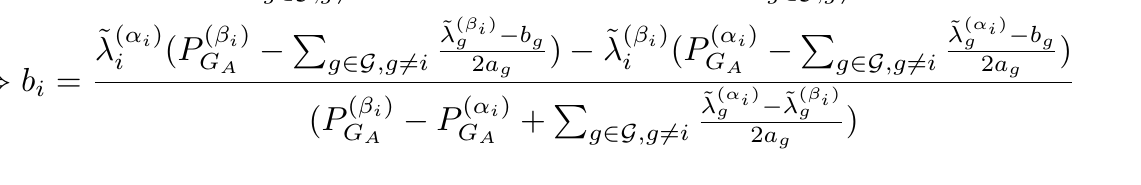

In [ ]:
def condition_check_for_b(LMP_arr,PG_aggregate,beta_i,alpha_i,i):
  flag = False
  b_min = np.array([19.0,19.0,39.0])
  b_max = np.array([21.0,21.0,41.0])
  lmp_a_b = LMP_arr[alpha_i,i]-LMP_arr[beta_i,i]
  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  C = 0
  D = LMP_arr[alpha_i,i]*PG_aggregate[beta_i]-LMP_arr[beta_i,i]*PG_aggregate[alpha_i]
  if D<0:
    return False
  #if B<0:
  #  return False
  #print('B:'+str(B)+',D:'+str(D)+',lmp_a_b:'+str(lmp_a_b))
  E = 0
  E_max = 0
  for g in range(0,LMP_arr.shape[1]):
      if g == i:
        continue
      C = C+(LMP_arr[alpha_i,g]-LMP_arr[beta_i,g])/(2*true_a[g])
      if lmp_a_b>0:
        #pdb.set_trace()
        e_min = lmp_a_b*b_min[g]
        e_max = lmp_a_b*b_max[g]
        E = E+((LMP_arr[beta_i,i]*LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]*LMP_arr[alpha_i,i])+e_min)/(2*true_a[g])
        E_max = E_max+((LMP_arr[beta_i,i]*LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]*LMP_arr[alpha_i,i])+e_max)/(2*true_a[g])
      else:
        e_min = lmp_a_b*b_min[g]
        e_max = lmp_a_b*b_max[g]
        #pdb.set_trace()
        E = E+((LMP_arr[beta_i,i]*LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]*LMP_arr[alpha_i,i])+e_max)/(2*true_a[g])
        E_max = E_max+((LMP_arr[beta_i,i]*LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]*LMP_arr[alpha_i,i])+e_min)/(2*true_a[g])
  A = B+C
  #pdb.set_trace()
  if A<=1e-5:
    return False
  #pdb.set_trace()
  lower_value = (D+E)/A
  upper_value = (D+E_max)/A
  if lower_value<b_min[i] or lower_value>b_max[i]:
    #print((D+E)/A)
    return False
  if upper_value>b_max[i] or upper_value<b_min[i]:
    #print((D+E_max)/A)
    return False
  #print('Self_mapping')
  cond = (LMP_arr[beta_i,i]-LMP_arr[alpha_i,i])/(2*A*true_a)
  print('the min value is:'+str(lower_value)+', the max value is:'+str(upper_value)+'cond:'+str(np.sum(abs(cond))))
  if np.sum(abs(cond))<1:
    #pdb.set_trace()
    flag=True
  return flag

In [ ]:
#LMP_arr[beta_i,i]*LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]*LMP_arr[alpha_i,i]
b_min = np.array([15.0,15.0,39.0])
b_max = np.array([25.0,25.0,41.0])

In [ ]:
LMP_arr.shape[1]

3

In [ ]:
def fb(adv_points,b_list):
  new_b_list = np.copy(b_list)
  for i in range(0,3):
    beta_i = adv_points[i][0]
    alpha_i = adv_points[i][1]
    B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
    C = 0
    d1 = 0
    d2 = 0
    for g in range(0,LMP_arr.shape[1]):
        if g == i:
          continue
        d1 = d1+(LMP_arr[beta_i,g]-b_list[g])/(2*true_a[g])
        d2 = d2+(LMP_arr[alpha_i,g]-b_list[g])/(2*true_a[g])
        C = C+(LMP_arr[alpha_i,g]-LMP_arr[beta_i,g])/(2*true_a[g])
        #pdb.set_trace()
    A = B+C
    #pdb.set_trace()
    new_b = (LMP_arr[alpha_i,i]*(PG_aggregate[beta_i]-d1)-LMP_arr[beta_i,i]*(PG_aggregate[alpha_i]-d2))/A
    new_b = np.clip(new_b,b_min[i]+0.001,b_max[i]-0.001)
    new_b_list[i] = new_b
  return new_b_list

In [ ]:
b_list = np.array([20.0,20.0,40.5])

In [ ]:
for jj in range(0,20):
  b_list = fb(adv_points,b_list)
  print(b_list)

[17.8478124  15.001      39.99999052]
[20.85984365 24.999      40.70012825]
[16.12619689 15.001      39.60019753]
[22.58018864 24.999      40.999     ]
[15.001      15.001      39.20038403]
[24.30062189 24.999      40.999     ]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]
[15.001 15.001 39.001]
[24.999 24.999 40.999]


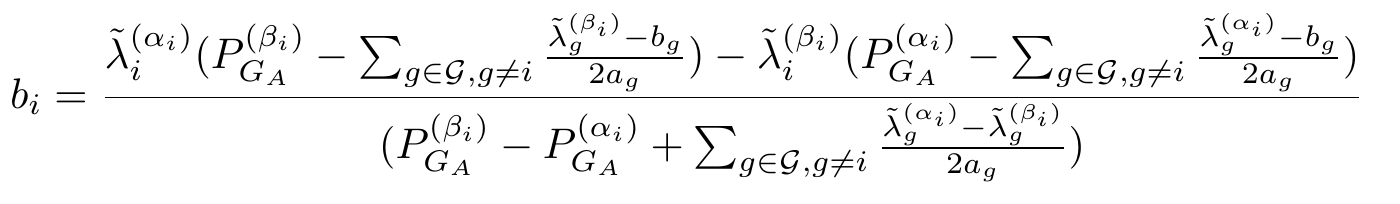

In [ ]:
LMP_arr[alpha_i,i]*PG_aggregate[beta_i]-LMP_arr[beta_i,i]*PG_aggregate[alpha_i]

np.float64(-121.61073177727667)

In [ ]:
A_list = []                # A1, A2, A3
D_list = []              # D1, D2, D3
f_list = []                # f1, f2, f2 (assumed reused)
a_list = true_a             # a1, a2, a3

In [ ]:
for i in range(0,3):
  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  C = 0
  d1 = 0
  d2 = 0
  D = LMP_arr[alpha_i,i]*PG_aggregate[beta_i]-LMP_arr[beta_i,i]*PG_aggregate[alpha_i]
  f = LMP_arr[alpha_i,i]-LMP_arr[beta_i,i]
  for g in range(0,LMP_arr.shape[1]):
      if g == i:
        continue
      d1 = d1+(LMP_arr[beta_i,g]-b_list[g])/(2*true_a[g])
      d2 = d2+(LMP_arr[alpha_i,g]-b_list[g])/(2*true_a[g])
      D=D+(LMP_arr[alpha_i,g]*LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]*LMP_arr[beta_i,g])/(2*true_a[g])
      C = C+(LMP_arr[alpha_i,g]-LMP_arr[beta_i,g])/(2*true_a[g])
  #pdb.set_trace()
  A = B+C
  #A_list.append(A)
  #D_list.append(D)
  #f_list.append(f)
  new_b = (LMP_arr[alpha_i,i]*(PG_aggregate[beta_i]-d1)-LMP_arr[beta_i,i]*(PG_aggregate[alpha_i]-d2))/A
  b_list[i]=new_b
  print(new_b)

NameError: name 'beta_i' is not defined

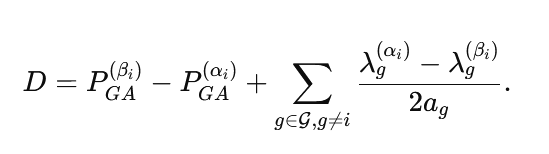

np.float64(1.9613632850992957)

In [ ]:
p_beta_1 =(LMP_arr[beta_i,1]-b_list[1])/(2*true_a[1])
p_beta_2 = (LMP_arr[beta_i,2]-b_list[2])/(2*true_a[2])

In [ ]:
p_alpha_1 =(LMP_arr[alpha_i,1]-b_list[1])/(2*true_a[1])
p_alpha_2 = (LMP_arr[alpha_i,2]-b_list[2])/(2*true_a[2])

In [ ]:
c1 = (LMP_arr[alpha_i,1]-LMP_arr[beta_i,1])/(2*true_a[1])
c2 = (LMP_arr[alpha_i,2]-LMP_arr[beta_i,2])/(2*true_a[2])
A = PG_aggregate[beta_i]-PG_aggregate[alpha_i]+c1+c2

In [ ]:
i=0
bb=((PG_aggregate[beta_i]-p_beta_1-p_beta_2)*LMP_arr[alpha_i,i]-(PG_aggregate[alpha_i]-p_alpha_1-p_alpha_2)*LMP_arr[beta_i,i])/((PG_aggregate[beta_i]-p_beta_1-p_beta_2)-(PG_aggregate[alpha_i]-p_alpha_1-p_alpha_2))
print(bb)

In [ ]:
adv_points

[array([6042,  645]), array([5805, 2400]), array([6879, 8924])]

In [ ]:
i=0
bb=(Pg_arr[beta_i,i]*LMP_arr[alpha_i,i]-Pg_arr[alpha_i,i]*LMP_arr[beta_i,i])/(Pg_arr[beta_i,i]-Pg_arr[alpha_i,i])
print(bb)

In [ ]:
true_b

array([20., 20., 40., 40., 40.])

In [ ]:
b_list = np.array([20.0,20.0,40.0])
for it in range(0,10):
  b_list = fb(adv_points,b_list)
  print(b_list)

[33.93233055 38.15576706 40.15748532]
[33.2996412  37.97042462 37.86635448]
[34.94526563 38.10351688 37.95562226]
[34.87754366 38.07776756 37.73150493]
[35.03873602 38.09086061 37.74119663]
[35.03142247 38.08828668 37.71924257]
[35.04721376 38.08957787 37.72028444]
[35.04643102 38.08932066 37.71813349]
[35.04797836 38.089448   37.71824458]
[35.04789516 38.08942232 37.71803379]


In [ ]:
b_list[0]

np.int64(20)

In [ ]:
alpha=0
beta = 1
gamma=2
con_0 = -2*(true_a[0])*PG_aggregate[alpha]+(true_a[0]*LMP_arr[alpha,1]/(true_a[1]))\
        +(true_a[0]*LMP_arr[alpha,2]/(true_a[2]))+LMP_arr[alpha,0]
con_1 = -2*(true_a[1])*PG_aggregate[beta]+(true_a[1]*LMP_arr[beta,0]/(true_a[0]))\
        +(true_a[1]*LMP_arr[beta,2]/(true_a[2]))+LMP_arr[beta,1]
con_2 = -2*(true_a[2])*PG_aggregate[gamma]+(true_a[2]*LMP_arr[gamma,0]/(true_a[0]))\
        +(true_a[2]*LMP_arr[gamma,1]/(true_a[1]))+LMP_arr[gamma,2]

In [ ]:
con_0

np.float64(195.55937015501755)

In [ ]:
A=np.array([[1,0.1721,4.3],[5.81,1,25],[0.2324,0.04,1]])

In [ ]:
B=np.array([[20],[20],[40]])

In [ ]:
C = np.zeros_like(B)
C[0,0] = con_0
C[1,0] = con_1
C[2,0] = con_2

In [ ]:
np.linalg.det(A)

np.float64(0.0)

In [ ]:
    import numpy as np

# Example inputs (replace with real data)
p1, p2, p3 = 0, 1, 3
# Build matrix A and rhs vector
A = np.eye(3)
rhs = np.zeros(3)

# Row 0
A[0,1] = true_a[0]/true_a[1]
A[0,2] = true_a[0]/true_a[2]
rhs[0] = LMP_arr[p1,0] - 2*true_a[0]*PG_aggregate[p1] + \
         (true_a[0]/true_a[1])*LMP_arr[p1,1] + (true_a[0]/true_a[2])*LMP_arr[p1,2]

# Row 1
A[1,0] = true_a[1]/true_a[0]
A[1,2] = true_a[1]/true_a[2]
rhs[1] = LMP_arr[p2,1] - 2*true_a[1]*PG_aggregate[p2] + \
         (true_a[1]/true_a[0])*LMP_arr[p2,0] + (true_a[1]/true_a[2])*LMP_arr[p2,2]

# Row 2
A[2,0] = true_a[2]/true_a[0]
A[2,1] = true_a[2]/true_a[1]
rhs[2] = LMP_arr[p3,2] - 2*true_a[2]*PG_aggregate[p3] + \
         (true_a[2]/true_a[0])*LMP_arr[p3,0] + (true_a[2]/true_a[1])*LMP_arr[p3,1]

b_solution, residuals, rank, s = np.linalg.lstsq(A, rhs, rcond=None)
print("Least-squares b:", b_solution)


Least-squares b: [10.0057002   1.7221515  43.05378746]


In [ ]:
true_b

array([20., 20., 40., 40., 40.])

In [ ]:
g_cardinality = len(g_index_list)
best_cond = np.ones(g_cardinality)*100
a_max = 0.5
def check_conditions(LMP_arr,PG_aggregate,beta_i,alpha_i,i):
  A = LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]
  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  if A<=0 or B<=0:
    return False
  C = 0
  C_exe_neg = 0
  C_exe_pos = 0
  for g in range(0,LMP_arr.shape[1]):
    if g == i:
      continue
    c = LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]
    if c<0:
      C_exe_neg = C_exe_neg+c
    else:
      C_exe_pos = C_exe_pos+c
    C = C+abs(c)
  cond = (math.sqrt(A*C)-C_exe_neg)/(2*B+C_exe_pos/a_max)
  if (A/(2*(B+C_exe_neg/(2*(cond))+C_exe_pos/(2*a_max)))<cond):
    #pdb.set_trace()
    return False

  if(cond<best_cond[i] and cond!=0):
    best_cond[i] = cond
    print(cond)
    #pdb.set_trace()
    print('Best cond:'+str(best_cond))
    return True
  else:
    return False
'''
g_cardinality = len(g_index_list)
def check_conditions(LMP_arr,PG_aggregate,beta_i,alpha_i,i):
  A = LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]
  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]
  if A<=0 or B<=0:
    return False
  for g in range(0,LMP_arr.shape[1]):
    if g == i:
      continue
    C = LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]
    if C<0:
      return False
  return True'''


'\ng_cardinality = len(g_index_list)\ndef check_conditions(LMP_arr,PG_aggregate,beta_i,alpha_i,i):\n  A = LMP_arr[beta_i,i]-LMP_arr[alpha_i,i]\n  B = PG_aggregate[beta_i]-PG_aggregate[alpha_i]\n  if A<=0 or B<=0:\n    return False\n  for g in range(0,LMP_arr.shape[1]):\n    if g == i:\n      continue\n    C = LMP_arr[alpha_i,g]-LMP_arr[beta_i,g]\n    if C<0:\n      return False\n  return True'

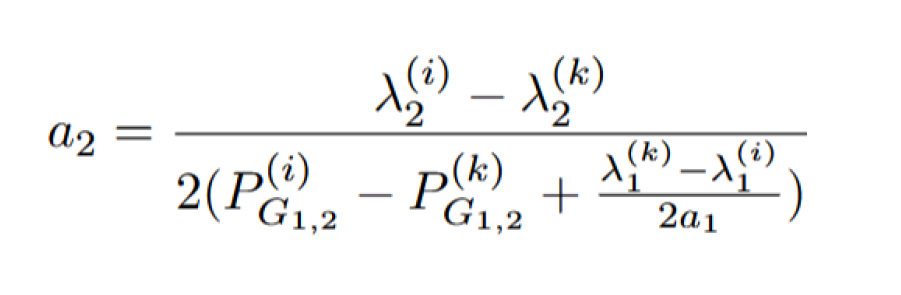

In [ ]:
a2=(LMP_g2[i]-LMP_g2[k])/(2*(Pg12[i]-Pg12[k]+(LMP_g1[k]-LMP_g1[i])/(2*a1)))

In [ ]:
a2

0.02222222242932816

In [ ]:
a1=0.01
b1=40
a2=0.01
b2=40
res1 = 2*a1 * (Pg12[i] - (LMP_g2[i] - b2) / (2*a2)) + b1 - LMP_g1[i]
res2 = 2*a2 * (Pg12[i] - (LMP_g1[i] - b1) / (2*a1)) + b2 - LMP_g2[i]
res3 = 2*a1 * (Pg12[j] - (LMP_g2[j] - b2) / (2*a2)) + b1 - LMP_g1[j]
res4 = 2*a2 * (Pg12[j] - (LMP_g1[j] - b1) / (2*a1)) + b2 - LMP_g2[j]
res5 = 2*a1 * (Pg12[k] - (LMP_g2[k] - b2) / (2*a2)) + b1 - LMP_g1[k]
res6 = 2*a2 * (Pg12[k] - (LMP_g1[k] - b1) / (2*a1)) + b2 - LMP_g2[k]
print(res1)
print(res2)

9.922574051302036e-07
9.922574051302036e-07


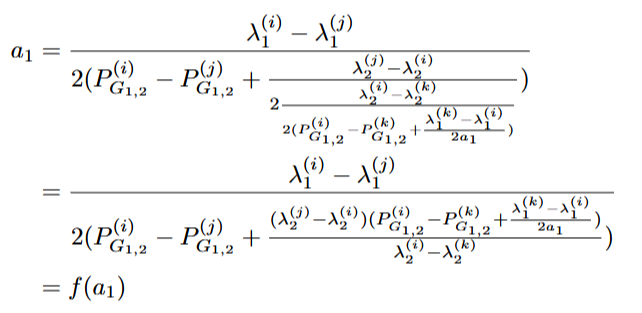

In [ ]:
def f_a1(lambda_1_i, lambda_1_j, lambda_1_k, lambda_2_i, lambda_2_j, lambda_2_k, P_G_i, P_G_j, P_G_k, a1):
    A = lambda_1_i - lambda_1_j
    B = P_G_i - P_G_j
    C = lambda_2_j - lambda_2_i
    D = P_G_i - P_G_k
    E = lambda_1_k - lambda_1_i
    F = lambda_2_i - lambda_2_k
    a2 = 0.5*F/(D+0.5*E/a1)
    fa1 = (lambda_1_i-lambda_1_j)/(2*(P_G_i-(lambda_2_i)/(2*a2)-P_G_j+(lambda_2_j)/(2*a2)))
    #print('a2:'+str(a2))
    return fa1

In [ ]:
a1 = 1
for pp in range(0,10):
  a1 = f_a1(LMP_g1[i], LMP_g1[j], LMP_g1[k], LMP_g2[i], LMP_g2[j], LMP_g2[k], Pg12[i], Pg12[j], Pg12[k], a1)
  print('a1:'+str(a1))

a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094
a1:0.009998641090778094


In [ ]:
a1 = 1
for pp in range(0,1):
  a1 = f_a1_2(LMP_g1[i], LMP_g1[j], LMP_g1[k], LMP_g2[i], LMP_g2[j], LMP_g2[k], Pg12[i], Pg12[j], Pg12[k], a1)
  print(a1)

NameError: name 'f_a1_2' is not defined

In [ ]:
matrix = np.array([[10, 25, 3],
                   [8, 15, 30],
                   [22, 5, 18]])

# Find index of max value
max_index = np.unravel_index(np.argmax(matrix), matrix.shape)

print("Index of max value:", max_index)

Index of max value: (1, 2)


In [ ]:
import tensorflow as tf
import numpy as np

# Define the variables to be learned (a1, a2, b1, b2)
# Initialize them with some values (e.g., 1.0)
#a1 = tf.Variable(1.0, dtype=tf.float32)
#a2 = tf.Variable(1.0, dtype=tf.float32)
#b1 = tf.Variable(1.0, dtype=tf.float32)
#b2 = tf.Variable(1.0, dtype=tf.float32)

# Define the input data (x1, x2, y)
# Example: Let's assume we have 5 data points
x1_data =LMP_g1
x2_data = LMP_g2
y_data = Pg12

# Define the model equation
def model(x1, x2):
    return (x1 - b1) / a1 + (x2 - b2) / a2

# Define the loss function (mean squared error)
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define the optimizer (e.g., Adam optimizer)
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Compute the predicted y
        y_pred = model(x1_data, x2_data)
        cons = tf.maximum(0,1000*a1-b1)+tf.maximum(0,1000*a2-b2)
        # Compute the loss
        loss = compute_loss(y_data, y_pred)+100*cons

    # Compute gradients
    gradients = tape.gradient(loss, [a1, a2, b1, b2])

    # Update the variables using the optimizer
    optimizer.apply_gradients(zip(gradients, [a1, a2, b1, b2]))

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

# Print the learned parameters
print("Learned parameters:")
print(f"a1: {a1.numpy()}, a2: {a2.numpy()}, b1: {b1.numpy()}, b2: {b2.numpy()}")

Epoch 100, Loss: 19.527847290039062
Epoch 200, Loss: 16.435810089111328
Epoch 300, Loss: 88.47554016113281
Epoch 400, Loss: 67.67384338378906
Epoch 500, Loss: 17.5920467376709
Epoch 600, Loss: 17.95403289794922
Epoch 700, Loss: 68.92300415039062
Epoch 800, Loss: 17.53510284423828
Epoch 900, Loss: 61.6577033996582
Epoch 1000, Loss: 22.434701919555664
Epoch 1100, Loss: 80.50341033935547
Epoch 1200, Loss: 57.3852424621582
Epoch 1300, Loss: 21.096080780029297
Epoch 1400, Loss: 80.34504699707031
Epoch 1500, Loss: 62.65080261230469
Epoch 1600, Loss: 18.346725463867188
Epoch 1700, Loss: 29.378585815429688
Epoch 1800, Loss: 52.181922912597656
Epoch 1900, Loss: 23.787256240844727
Epoch 2000, Loss: 17.339969635009766
Epoch 2100, Loss: 16.240808486938477
Epoch 2200, Loss: 246.60696411132812
Epoch 2300, Loss: 42.2736701965332
Epoch 2400, Loss: 80.51805114746094
Epoch 2500, Loss: 50.801700592041016
Epoch 2600, Loss: 26.925983428955078
Epoch 2700, Loss: 20.129018783569336
Epoch 2800, Loss: 17.637489

In [ ]:
# Print the learned parameters
print("Learned parameters:")
print(f"a1: {a1.numpy()}, a2: {a2.numpy()}, b1: {b1.numpy()}, b2: {b2.numpy()}")

Learned parameters:
a1: 0.03202766180038452, a2: 0.03354857489466667, b1: 39.52872085571289, b2: 39.958473205566406


In [ ]:
import numpy as np
from scipy.optimize import fsolve

def equations(vars, P_G_i, P_G_j, P_G_k,P_G_l, lambda_1_i, lambda_1_j, lambda_1_k,lambda_1_l, lambda_2_i, lambda_2_j, lambda_2_k, lambda_2_l):
    a1, a2, b1, b2 = vars
    eq1 = P_G_i-0.5*(lambda_1_i-b1)/a1-0.5*(LMP_g2[i]-b2)/a2
    eq2 = P_G_j-0.5*(lambda_1_j-b1)/a1-0.5*(LMP_g2[j]-b2)/a2
    eq3 = P_G_k-0.5*(lambda_1_k-b1)/a1-0.5*(LMP_g2[k]-b2)/a2
    eq4 = P_G_l-0.5*(lambda_1_l-b1)/a1-0.5*(LMP_g2[l]-b2)/a2
    return [eq1, eq2, eq3, eq4]

# Initial guesses
initial_guess = [1, 1, 1, 1]

# Example numerical values (replace these with real values)
P_G_i, P_G_j, P_G_k, P_G_l = Pg12[i], Pg12[j], Pg12[k], Pg12[l]
lambda_1_i, lambda_1_j, lambda_1_k, lambda_1_l = LMP_g1[i], LMP_g1[j], LMP_g1[k], LMP_g1[l]
lambda_2_i, lambda_2_j, lambda_2_k, lambda_2_l = LMP_g2[i], LMP_g2[j], LMP_g2[k], LMP_g2[l]

# Solve the nonlinear system
solution = fsolve(equations, initial_guess, args=(P_G_i, P_G_j, P_G_k,P_G_l, lambda_1_i, lambda_1_j, lambda_1_k,lambda_1_l, lambda_2_i, lambda_2_j, lambda_2_k, lambda_2_l))

print(f"Solved values: a1 = {solution[0]}, a2 = {solution[1]}, b1 = {solution[2]}, b2 = {solution[3]}")


Solved values: a1 = 0.05554038644192397, a2 = 0.05553259128677515, b1 = -45394.15925669617, b2 = 45462.26502852754


<ipython-input-16-56eef06283b9>:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  solution = fsolve(equations, initial_guess, args=(P_G_i, P_G_j, P_G_k,P_G_l, lambda_1_i, lambda_1_j, lambda_1_k,lambda_1_l, lambda_2_i, lambda_2_j, lambda_2_k, lambda_2_l))


In [ ]:
import numpy as np
from scipy.optimize import least_squares

def equations(vars, P_G_i, P_G_j, P_G_k, lambda_1_i, lambda_1_j, lambda_1_k, lambda_2_i, lambda_2_j, lambda_2_k):
    a1, a2, b1, b2 = vars
    eq1 = 2 * a1 * (P_G_i - (lambda_2_i - b2) / (2 * a2)) + b1 - lambda_1_i
    eq2 = 2 * a2 * (P_G_i - (lambda_1_i - b1) / (2 * a1)) + b2 - lambda_2_i
    eq3 = 2 * a1 * (P_G_j - (lambda_2_j - b2) / (2 * a2)) + b1 - lambda_1_j
    eq4 = 2 * a2 * (P_G_k - (lambda_1_k - b1) / (2 * a1)) + b2 - lambda_2_k
    eq5 = (lambda_2_i - b2) / (2 * a2) + (lambda_1_i - b1) / (2 * a1) - P_G_i  # Extra constraint

    return [eq1, eq2, eq3, eq4, eq5]  # Overdetermined system

def constrained_solver(P_G_i, P_G_j, P_G_k, lambda_1_i, lambda_1_j, lambda_1_k, lambda_2_i, lambda_2_j, lambda_2_k):
    initial_guess = [0.01, 0.01, 40, 40]  # Ensure positive b1, b2
    bounds = [(1e-6, None), (1e-6, None), (0, None), (0, None)]  # Ensure positivity

    # Use least_squares to solve with bounds
    result = least_squares(
        equations, initial_guess,
        args=(P_G_i, P_G_j, P_G_k, lambda_1_i, lambda_1_j, lambda_1_k, lambda_2_i, lambda_2_j, lambda_2_k),
        bounds=([b[0] for b in bounds], [b[1] for b in bounds])  # Apply bounds
    )

    return result.x  # Return optimized values


# Example numerical values (replace these with real values)
P_G_i, P_G_j, P_G_k = Pg12[i], Pg12[j], Pg12[k]
lambda_1_i, lambda_1_j, lambda_1_k = LMP_g1[i], LMP_g1[j], LMP_g1[k]
lambda_2_i, lambda_2_j, lambda_2_k = LMP_g2[i], LMP_g2[j], LMP_g2[k]

solution = constrained_solver(P_G_i, P_G_j, P_G_k, lambda_1_i, lambda_1_j, lambda_1_k, lambda_2_i, lambda_2_j, lambda_2_k)
print(f"Solved values: a1 = {solution[0]}, a2 = {solution[1]}, b1 = {solution[2]}, b2 = {solution[3]}")


Initial guess: [0.01, 0.01, 0.1, 0.1]
Bounds: [(1e-06, None), (1e-06, None), (0, None), (0, None)]
Error: Initial guess was infeasible. Adjusting and retrying...


ValueError: `x0` is infeasible.

In [ ]:
a1=0.01
b1=40
a2=0.0222222222222
b2=20
i=np.argmax(LMP_i)
j=np.argmax(LMP_j)
res1 = 2*a1 * (P[i] - (x2[i] - b2) / (2*a2)) + b1 - x1[i]
res2 = 2*a2 * (P[i] - (x1[i] - b1) / (2*a1)) + b2 - x2[i]
res3 = 2*a1 * (P[j] - (x2[j] - b2) / (2*a2)) + b1 - x1[j]
res4 = 2*a2 * (P[j] - (x1[j] - b1) / (2*a1)) + b2 - x2[j]
print(res3)
print(res4)

2.2790121789739715e-07
5.064471508831048e-07


In [ ]:
2*a1*(P[i]-P[j]+(x2[j]-x2[i])/(2*a2))+x1[j]-x1[i]

-6.338006173223221e-07

In [ ]:
a1-(x1[i]-x1[j])/(2*(P[i]-P[j]+(x2[j]-x2[i])/(2*a2)))

-1.690791740470432e-08

In [ ]:
a2-(x2[i]-x2[j])/(2*(P[i]-P[j]+(x1[j]-x1[i])/(2*a1)))

5.468098256307397e-07

In [ ]:
print(P[i])
print(x1[i])
print(x2[i])

472.40695745135497
41.211144442114865
38.304433584007555


In [ ]:
print(P[j])
print(x1[j])
print(x2[j])

454.95208428776544
40.83628947140788
38.361671080973224


In [ ]:
import numpy as np
from scipy.optimize import fsolve

# Define the system of nonlinear equations
def equations(vars):
    a1, a2 = vars

    # Equation 5 (simplified form from previous steps)
    E5 = 2 * a1 * (373.8874094001285 - (36.61721765015928 - (38.304433584007555 - 2 * a2 * (472.40695745135497 - (41.211144442114865 - 2 * a1 * (472.40695745135497 - (38.304433584007555 - 2 * a2 * (472.40695745135497 - (41.211144442114865 - 2 * a1 * (472.40695745135497))))))))) / (2 * a2)) \
         + (41.211144442114865 - 2 * a1 * (472.40695745135497 - (38.304433584007555 - 2 * a2 * (472.40695745135497 - (41.211144442114865 - 2 * a1 * (472.40695745135497)))))) - 38.928850625170156

    # Equation 6 (simplified form from previous steps)
    E6 = 2 * a2 * (373.8874094001285 - (38.928850625170156 - (41.211144442114865 - 2 * a1 * (472.40695745135497 - (38.304433584007555 - 2 * a2 * (472.40695745135497 - (41.211144442114865 - 2 * a1 * (472.40695745135497)))))))) / (2 * a1)) \
         + (38.304433584007555 - 2 * a2 * (472.40695745135497 - (41.211144442114865 - 2 * a1 * (472.40695745135497)))) - 36.61721765015928

    return [E5, E6]

# Initial guesses
initial_guess = [0.01, 0.01]

# Solve for a1, a2
solution = fsolve(equations, initial_guess)

a1_sol, a2_sol = solution

# Print results
print(f"Estimated parameters:")
print(f"a1 = {a1_sol:.6f}, a2 = {a2_sol:.6f}")


SyntaxError: unmatched ')' (<ipython-input-9-0f2b958e462c>, line 13)

In [ ]:
import numpy as np
from scipy.optimize import least_squares

# Define the system of equations to minimize residuals
def equations(vars, P, x1, x2):
    a1, b1, a2, b2 = vars
    eq1 = 2*a1 * (P - (x2 - b2) / (2*a2)) + b1 - x1
    eq2 = 2*a2 * (P - (x1 - b1) / (2*a1)) + b2 - x2
    return np.concatenate((eq1, eq2))

# Initial guess for parameters (a1, b1, a2, b2)
initial_guess = [1, 1, 1, 1]

# Set bounds to enforce non-negative constraints on a1 and a2
bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

# Solve using least squares with constraints
solution = least_squares(equations, initial_guess, args=(P, x1, x2), bounds=bounds)

# Extract estimated parameters
a1_sol, b1_sol, a2_sol, b2_sol = solution.x

# Print results
print(f"Estimated parameters:")
print(f"a1 = {a1_sol:.4f}, b1 = {b1_sol:.4f}, a2 = {a2_sol:.4f}, b2 = {b2_sol:.4f}")

# Compute residual error for verification
residuals = equations([a1_sol, b1_sol, a2_sol, b2_sol], P, x1, x2)
mean_residual_error = np.mean(np.abs(residuals))

# Print mean absolute residual error
print(f"Mean absolute residual error: {mean_residual_error:.4f}")


Estimated parameters:
a1 = 0.0107, b1 = 33.5714, a2 = 0.0196, b2 = 33.8188
Mean absolute residual error: 0.0141


In [ ]:
P[np.argmin(LMP_i)]

373.8874094001285

In [ ]:
LMP_j

array([37.97717648, 37.91655095, 37.84418979, ..., 38.00190863,
       37.92805708, 37.98371877])

In [ ]:
(P[0] - (x2[0] - 20) / (2*0.0222))

25.394927949901614

In [ ]:
Pi[0]

25.799822161837227

Estimated parameters:
a1 = 0.010701, b1 = 52.075882, a2 = 0.019557, b2 = 0.000012
Mean absolute residual error: 0.014054


In [ ]:
import numpy as np
from scipy.optimize import fsolve

# Define the system of 4 nonlinear equations
def equations(vars, P_vals, x1_vals, x2_vals):
    a1, b1, a2, b2 = vars
    eqs = [
        2 * a1 * (P_vals[0] - (x2_vals[0] - b2) / (2 * a2)) + b1 - x1_vals[0],
        2 * a2 * (P_vals[0] - (x1_vals[0] - b1) / (2 * a1)) + b2 - x2_vals[0],

        2 * a1 * (P_vals[1] - (x2_vals[1] - b2) / (2 * a2)) + b1 - x1_vals[1],
        2 * a2 * (P_vals[1] - (x1_vals[1] - b1) / (2 * a1)) + b2 - x2_vals[1]
    ]
    return eqs

# Example dataset (only 2 data points because we have 4 equations)
P_vals = np.array([472.40695745135497, 373.8874094001285])
x1_vals = np.array([41.211144442114865, 38.928850625170156])
x2_vals = np.array([38.304433584007555, 36.61721765015928])

# Initial guess for [a1, b1, a2, b2]
initial_guess = [0.01, 1, 0.01, 1]  # Reasonable starting point

# Solve for unknowns
solution = fsolve(equations, initial_guess, args=(P_vals, x1_vals, x2_vals))

# Extract estimated parameters
a1_sol, b1_sol, a2_sol, b2_sol = solution

# Print results
print(f"Estimated parameters:")
print(f"a1 = {a1_sol:.6f}, b1 = {b1_sol:.6f}, a2 = {a2_sol:.6f}, b2 = {b2_sol:.6f}")


Estimated parameters:
a1 = 0.020146, b1 = 30.561287, a2 = 0.020146, b2 = 29.920261


Estimated parameters:
a1 = 0.0107, b1 = 46.5429, a2 = 0.0196, b2 = 10.1122
Mean absolute residual error: 0.0141


In [ ]:
x1 = LMP_1.reshape([n_points,1])
X = np.hstack([np.ones([n_points,1]),x1])

In [ ]:
y=P1.reshape(n_points,1)

In [ ]:
theta=np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)

In [ ]:
theta

array([[-1999.99386273],
       [   49.99984964]])

In [ ]:
a=1/theta[1,0]/2
b=a*theta[0,0]*-2

In [ ]:
print(a)
print(b)

0.010000030072762203
39.99999754523531


In [ ]:
X.shape

(1000, 2)

In [ ]:
import numpy as np

# Given y values
y_data = LMP_1  # Replace with your actual y values

# Known x range
x_min = 0  # Define x_min
x_max = 100  # Define x_max

# Compute statistics
E_y = np.mean(y_data)  # Mean of y
sigma_y = np.std(y_data, ddof=1)  # Standard deviation of y

E_x = (x_min + x_max) / 2  # Expected mean of x
sigma_x = (x_max - x_min) / np.sqrt(12)  # Approximate standard deviation of x

# Estimate a and b
a_est = sigma_y / sigma_x
b_est = E_y - a_est * E_x

print(f"Estimated a: {a_est:.4f}")
print(f"Estimated b: {b_est:.4f}")


Estimated a: 0.0031
Estimated b: 40.3739


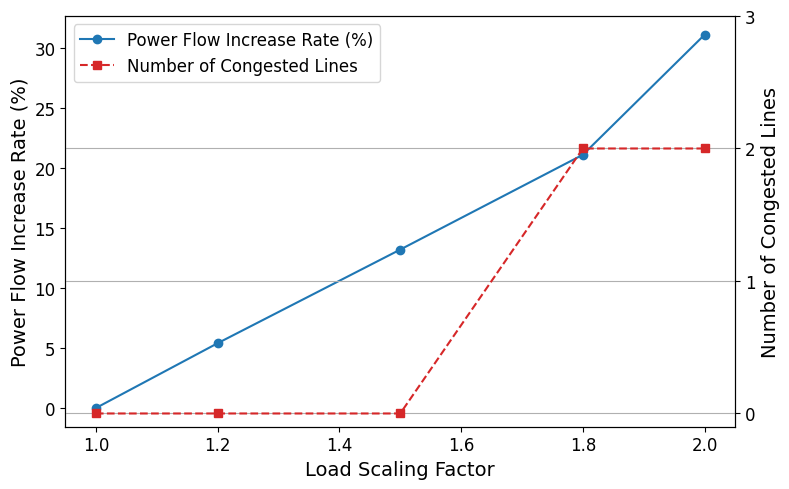

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
load_factors = [1.0, 1.2, 1.5, 1.8, 2.0]
increase_rates = [0, 5.4, 13.2, 21.1, 31.1]  # Percentage
congested_lines = [0, 0, 0, 2, 2]  # Integer count

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Font size config
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16
legend_fontsize = 12

# Plot power flow increase rate as line
line1, = ax1.plot(load_factors, increase_rates, marker='o', color='tab:blue', label='Power Flow Increase Rate (%)')
ax1.set_xlabel('Load Scaling Factor', fontsize=label_fontsize)
ax1.set_ylabel('Power Flow Increase Rate (%)', fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Secondary axis for congested lines (dashed line plot)
ax2 = ax1.twinx()
line2, = ax2.plot(load_factors, congested_lines, marker='s', linestyle='--', color='tab:red', label='Number of Congested Lines')
ax2.set_ylabel('Number of Congested Lines', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax2.set_yticks(np.arange(0, max(congested_lines) + 2, 1))

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=legend_fontsize)

# Title and layout
#plt.title('System Stress with Load Scaling', fontsize=title_fontsize)
fig.tight_layout()
plt.grid(True)
plt.show()


UsageError: Line magic function `%plt.title('System` not found.


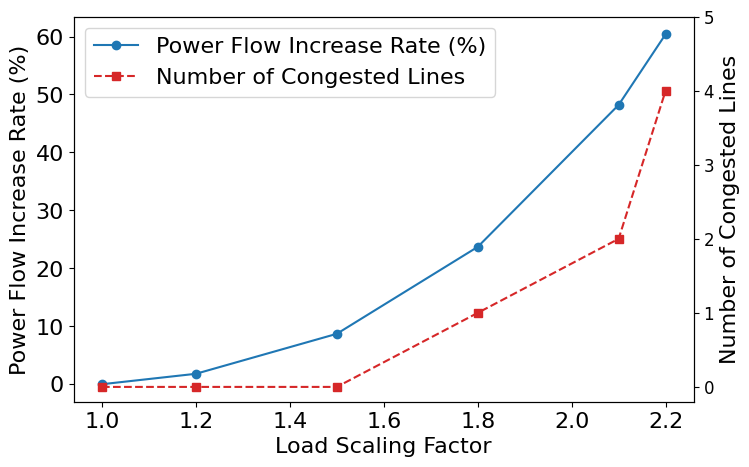

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
title_fontsize = 16
# Data from the image
load_factors = [1.0, 1.2, 1.5, 1.8, 2.1, 2.2]
increase_rates = [0.0, 1.8, 8.7, 23.7, 48.2, 60.4]  # Power Flow Increase Rate (%)
congested_lines = [0, 0, 0, 1, 2, 4]  # Number of Congested Lines

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Power Flow Increase Rate
color1 = 'tab:blue'
line1, = ax1.plot(load_factors, increase_rates, marker='o', color=color1, label='Power Flow Increase Rate (%)')
ax1.set_xlabel('Load Scaling Factor', fontsize=title_fontsize)
ax1.set_ylabel('Power Flow Increase Rate (%)', fontsize=title_fontsize)
ax1.tick_params(axis='y', labelsize=title_fontsize)
ax1.tick_params(axis='x', labelsize=title_fontsize)

# Plot Number of Congested Lines on the secondary y-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
line2, = ax2.plot(load_factors, congested_lines, marker='s', linestyle='--', color=color2, label='Number of Congested Lines')
ax2.set_ylabel('Number of Congested Lines', fontsize=title_fontsize, )
ax2.tick_params(axis='y',  labelsize=12)
ax2.set_yticks(np.arange(0, max(congested_lines) + 2, 1))  # Integer ticks only

# Add legend
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=title_fontsize)

# Title and layout
%plt.title('System Stress under Uniform Load Increase', fontsize=16)
fig.tight_layout()
plt.grid(True)
plt.show()
